In [41]:

!pip3 install wordninja==2.0.0             # for splitting joined words
!pip3 install scikit-learn==0.22.2         # for one-hot encoding
!pip3 install lime==0.2.0                  # for explaining model predictions
!pip3 install tensorflow

In [42]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import tensorflow as tf
# Check if any GPU is detected
print("Is GPU available: ", tf.test.is_gpu_available())
print("GPU(s) found: ")
print(tf.config.experimental.list_physical_devices('GPU'))

Is GPU available:  False
GPU(s) found: 
[]


In [43]:
data_path = os.getcwd().replace('script', 'data')
print(data_path)
data = pd.read_pickle(data_path + '/sentiment_data.pkl.zip')

/Users/zhuzeyu/Desktop/COMP3359/Project/COMP__3359__GROUP8/data


In [44]:
data["label"] = data["label"].str[9:10]
data.head()

,label,text
0,2,xcellent home help for parents: Volume 1 of Do...
1,1,"tay far, far away.: I made it through about 6,..."
2,1,ost Woods: Lost WoodsI didn't really understan...
3,1,"enaissance -12, Women's brown suead shoes: Rec..."
4,2,est Novel I've Read This Year: Intrigued by th...


In [45]:
glove_path = data_path + '/glove.6B.50d.txt'
glove_path

'/Users/zhuzeyu/Desktop/COMP3359/Project/COMP__3359__GROUP8/data/glove.6B.50d.txt'

In [46]:
data=data.sample(frac=0.1, replace=False, random_state=1).reset_index().drop(columns = ["index"])

In [47]:
from string import punctuation
from collections import defaultdict
import numpy as np

def load_embedding_from_disks(glove_filename, with_indexes=True):
    """
    Read a GloVe txt file. If `with_indexes=True`, we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
    else:
        word_to_embedding_dict = dict()

    
    with open(glove_filename, 'r') as glove_file:
        for (i, line) in enumerate(glove_file):
            
            split = line.split(' ')
            
            word = split[0]
            
            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )
            
            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    _WORD_NOT_FOUND = [0.0]* len(representation)  # Empty representation for unknown words.
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict


def sentence_to_word_ids(sentence, word_to_index):
    """
    Note: there might be a better way to split sentences for GloVe.
    Please look at the documentation or open an issue to suggest a fix.
    """
    # Separating punctuation from words:
    for punctuation_character in punctuation:
        sentence = sentence.replace(punctuation_character, " {} ".format(punctuation_character))
    # Removing double spaces and lowercasing:
    sentence = sentence.replace("  ", " ").replace("  ", " ").lower().strip()
    # Splitting on every space:
    split_sentence = sentence.split(" ")
    # Converting to IDs:
    ids = [word_to_index[w.strip()] for w in split_sentence]
    return ids, split_sentence

In [48]:
word_to_index_dict, index_to_embedding_array = load_embedding_from_disks(glove_path, with_indexes=True)
index_to_embedding_array.shape

(400002, 50)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = data['text'].to_numpy()
y_beforelabel = data['label'].to_numpy()
le_y = preprocessing.LabelEncoder()
oe_y = preprocessing.OneHotEncoder()
temp_y = le_y.fit_transform(y_beforelabel).reshape(-1, 1)
X_train, X_traindev, temp_y_train, temp_y_traindev = train_test_split(X, temp_y, test_size=0.2, random_state=42)
y_train = oe_y.fit_transform(temp_y_train).toarray()
y_traindev = oe_y.fit_transform(temp_y_traindev).toarray()

In [50]:
X_train.size

20160

In [51]:
def make_complete(x):
    #length = max(map(len, x))
    length = 400
    return np.array([xi+[0]*(length-len(xi)) for xi in x])

In [52]:
X_train_token = make_complete( sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_train  )
X_traindev_token = make_complete([ sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_traindev ])

In [53]:
X_train_token

array([[   219,    841,     45, ...,      0,      0,      0],
       [400001,  28457,   1999, ...,      0,      0,      0],
       [ 21864,    242,   1946, ...,      0,      0,      0],
       ...,
       [400001,     45,      0, ...,      0,      0,      0],
       [   269,     81,     40, ...,      0,      0,      0],
       [184179,  54037,     45, ...,      0,      0,      0]])

In [60]:
BATCH_SIZE = 128
# Training set data pipeline
train_ds_glove = tf.data.Dataset.from_tensor_slices((X_train_token, y_train))   
train_ds_glove = train_ds_glove.shuffle(buffer_size=len(X_train_token))                
train_ds_glove = train_ds_glove.batch(batch_size=BATCH_SIZE)                     
# Test set data pipeline
traindev_ds_glove = tf.data.Dataset.from_tensor_slices((X_traindev_token, y_traindev))
traindev_ds_glove = traindev_ds_glove.batch(batch_size=BATCH_SIZE)

In [61]:
""" Text Classification with RNN Model """
# Construct model

vocab_size, embedding_dim = index_to_embedding_array.shape



model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile model
model_rnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

# Train model
history = model_rnn.fit(train_ds_glove, epochs=10,
                        validation_data=traindev_ds_glove, 
                        validation_steps=30)

Epoch 1/10
158/158 [==============================] - 132s 777ms/step - loss: 0.6917 - accuracy: 0.5418 - val_loss: 0.6525 - val_accuracy: 0.6581
Epoch 2/10
158/158 [==============================] - 218s 1s/step - loss: 0.5648 - accuracy: 0.7445 - val_loss: 0.4176 - val_accuracy: 0.8365
Epoch 3/10
158/158 [==============================] - 4271s 27s/step - loss: 0.3537 - accuracy: 0.8674 - val_loss: 0.3357 - val_accuracy: 0.8648
Epoch 4/10
158/158 [==============================] - 6013s 38s/step - loss: 0.2434 - accuracy: 0.9133 - val_loss: 0.3132 - val_accuracy: 0.8721
Epoch 5/10
158/158 [==============================] - 5799s 37s/step - loss: 0.1930 - accuracy: 0.9312 - val_loss: 0.3367 - val_accuracy: 0.8716
Epoch 6/10
158/158 [==============================] - 3793s 24s/step - loss: 0.1564 - accuracy: 0.9447 - val_loss: 0.3166 - val_accuracy: 0.8711
Epoch 7/10
158/158 [==============================] - 5851s 24s/step - loss: 0.1257 - accuracy: 0.9611 - val_loss: 0.3734 - val_acc

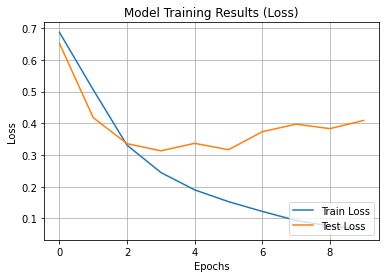

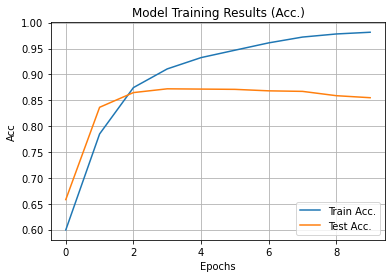

In [62]:

##### Loss #####
# Get training results
history_dict = history.history
train_loss = history_dict['loss']
test_loss = history_dict['val_loss']

# Plot training results
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

# Show plot
plt.title('Model Training Results (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### Accuracy #####
# Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

# Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

# Show plot
plt.title('Model Training Results (Acc.)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()

In [63]:

# prediction example
from scipy import stats
example = X_train[0]
corresponding_output = y_train[0]

print("Sentence: \n",
      example, "\n")
ids = sentence_to_word_ids(example, word_to_index_dict)[0]
print("Corresponding ids: \n",
      ids, "\n")
predictions = np.amin(model_rnn.predict(ids), axis=0)
print("Corresponding predictions: \n",
      predictions, "\n")
print("Final prediction: \n", 
      le_y.inverse_transform(stats.mode(predictions)[0].astype(int))[0], "\n")
print("Actual categorization: \n", 
     list(le_y.classes_)[oe_y.inverse_transform([corresponding_output])[0][0]])

Sentence: 
  good try: I enjoyed this album, and I felt that the most enjoyable songs were "These Good Old Dreams" (a nice choice to open the CD with), "Strength of a Woman", "Back In My Life Again", and my favorite, "Touch Me When We're Dancing".I think the only low point of the album was "Beechwood", and I agree with the other reviewer that it should've been left off the album in favor of another song. I always cry at "The Wedding Song" (especially the last refrain) when I think about how unhappy her marriage was and how her life ended so tragically. We miss you, Karen! 

Corresponding ids: 
 [219, 841, 45, 41, 3978, 37, 597, 1, 5, 41, 1349, 12, 0, 96, 19612, 1499, 35, 8, 158, 219, 167, 5559, 8, 23, 7, 3082, 1675, 4, 310, 0, 3537, 17, 24, 1, 8, 2174, 3, 7, 787, 8, 1, 8, 137, 6, 192, 214, 378, 8, 1, 5, 192, 2706, 1, 8, 3255, 285, 61, 53, 57, 1765, 5365, 8, 2, 41, 269, 0, 91, 653, 389, 3, 0, 597, 15, 8, 87706, 8, 1, 5, 41, 2137, 17, 0, 68, 15644, 12, 20, 189, 57, 37138, 51, 218, 138, 0

In [64]:
model_rnn.save(data_path + "model_rnn_sentiment.h5")